### Basic importing of modules, clever loop for importing all raw data frames efficiently

In [2]:
import glob
import os
import pandas as pd

folder_paths = ["Controls", "LC", "ME"]

# Dictionaries to hold DataFrames and headers for each folder
all_dfs = {}
all_headers = {}

for path in folder_paths:
    csv_files = glob.glob(os.path.join(path, '*.xlsx'))
    print(csv_files)
    # Read data without headers, skipping the first 3 rows
    dfs = [pd.read_excel(file, header=None, skiprows=3) for file in csv_files]
    
    # Read the header row separately (the row just before the data starts, so skiprows=2)
    headers = [pd.read_excel(file, nrows=1, header=None) for file in csv_files]
    
    # Assign the header row to each DataFrame
    for df, header in zip(dfs, headers):
        df.columns = header.iloc[0]
        
    # Store the DataFrames and headers in the dictionaries
    all_dfs[path] = dfs
    all_headers[path] = headers

# 25 seconds

['Controls\\P110061.xlsx', 'Controls\\P110090.xlsx', 'Controls\\P110096.xlsx', 'Controls\\P110097.xlsx', 'Controls\\P110098.xlsx', 'Controls\\P110099.xlsx', 'Controls\\P110101.xlsx', 'Controls\\P110102.xlsx', 'Controls\\P110103.xlsx', 'Controls\\P110104.xlsx', 'Controls\\P110106.xlsx', 'Controls\\P110107.xlsx', 'Controls\\P110109.xlsx', 'Controls\\P110110.xlsx', 'Controls\\P110112.xlsx', 'Controls\\P110114.xlsx', 'Controls\\P110115.xlsx', 'Controls\\P110126_P110126_CPET.xlsx', 'Controls\\P110132_P110132_CPET.xlsx', 'Controls\\P110139_P110139_CPET.xlsx', 'Controls\\P110140_110140_CPET.xlsx', 'Controls\\P110148_P110148_CPET.xlsx', 'Controls\\P110149_P110149_CPET.xlsx', 'Controls\\P110150_P110150_CPET.xlsx', 'Controls\\P110151_P110151_CPET.xlsx', 'Controls\\P110152_P110152_CPET.xlsx']
['LC\\P110017.xlsx', 'LC\\P110039.xlsx', 'LC\\P110050.xlsx', 'LC\\P110051.xlsx', 'LC\\P110055.xlsx', 'LC\\P110056.xlsx', 'LC\\P110058.xlsx', 'LC\\P110064.xlsx', 'LC\\P110085.xlsx', 'LC\\P110086.xlsx', 'LC\\P

### Create a copy of the grouped data frame to work with, to avoid having to import all the data frames over and over again

In [3]:
all_dfs_c = {'Controls':[], 'LC':[], 'ME':[]}
groups = ['Controls', 'LC', 'ME']
for group in groups:
    group_list = []
    for df in all_dfs[group]:
        group_list.append(df.copy())
    all_dfs_c[group] = group_list

### Count the amount of dataframes with missing columns_to_keep, and identify missing columns

In [4]:
cols_to_use = ['t', 'Power', 'HR', 'VE', 'VO2', 'VCO2', 'PetCO2', 'PetO2', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te', 'Phase']
count = {col: 0 for col in cols_to_use}
no_count = {col: 0 for col in cols_to_use}
for group_name, group in all_dfs_c.items():
    for df in group:
        for col in cols_to_use:
            if col in df.columns:
                count[col] += 1
            else:
                no_count[col] += 1
print(count)
print(no_count)
for i in no_count:
    if no_count[i] > 0:
        print(i)
        print(no_count[i])

{'t': 63, 'Power': 63, 'HR': 60, 'VE': 63, 'VO2': 63, 'VCO2': 63, 'PetCO2': 63, 'PetO2': 63, 'VO2/Kg': 63, 'VE/VO2': 63, 'VE/VCO2': 63, 'RQ': 63, 'VT': 63, 'Rf': 63, 'Ti': 63, 'Te': 63, 'Phase': 63}
{'t': 0, 'Power': 0, 'HR': 3, 'VE': 0, 'VO2': 0, 'VCO2': 0, 'PetCO2': 0, 'PetO2': 0, 'VO2/Kg': 0, 'VE/VO2': 0, 'VE/VCO2': 0, 'RQ': 0, 'VT': 0, 'Rf': 0, 'Ti': 0, 'Te': 0, 'Phase': 0}
HR
3


### Remove unwanted columns, and subsequently removing NaN's   


In [5]:
for group_name, group in all_dfs_c.items():
    for df in group:
        col_rem_2b = [col for col in df.columns if col not in cols_to_use]
        df.drop(columns = col_rem_2b, inplace = True)

for group_name, group in all_dfs_c.items():
    for df in group:
        df.dropna(inplace=True)
Control = all_dfs_c['Controls']
LC = all_dfs_c['LC']
ME = all_dfs_c['ME']

for groupname, group in all_dfs_c.items():
    for i,df in enumerate(group):
        df['Participant'] = f'{groupname}_{i}'

### Concat all dataframes of a single participant group, and change the column order

In [9]:
Control_df = pd.concat((Control), axis = 0)
LC_df = pd.concat((LC), axis = 0)
ME_df = pd.concat((ME), axis = 0)

col_order = ['t', 'Power', 'HR', 'VE', 'VO2', 'VCO2', 'PetCO2', 'PetO2', 'VO2/Kg', 'VE/VO2', 'VE/VCO2', 'RQ', 'VT', 'Rf', 'Ti', 'Te', 'Participant', 'Phase']
Control_df = Control_df[col_order]
LC_df = LC_df[col_order]
ME_df = ME_df[col_order]

CHANGING DATE STRING TO SECONDS

In [10]:
def hhmmss_to_seconds(hhmmss):
    h, m, s = map(int, hhmmss.split(':'))
    return h * 3600 + m * 60 + s

for df in [Control_df, LC_df, ME_df]:
    df['t'] = df['t'].astype('string')
    df['t'] = df['t'].apply(hhmmss_to_seconds)


### Remove trials where the participant is not exercising (See paper for more information)

In [175]:
import copy
Control_df_edit = copy.deepcopy(Control_df)
ME_df_edit = copy.deepcopy(ME_df)
edit_c = dict(zip(['Controls_' + str(i) for i in range(21,26)], [190, 388, 331, 412, 290]))

edit_ME = dict(zip(['ME_' + str(i) for i in range(22,26)], [318, 332, 350, 238]))
Control_df_edit.reset_index(inplace = True)
ME_df_edit.reset_index(inplace = True)
for edit, df in zip([edit_c, edit_ME], [Control_df_edit, ME_df_edit]):
    to_drop = []
    for participant in edit.keys():
        start_exercise = df.groupby('Participant').head(1).index.tolist()[int(participant[-2:])]
        end_exercise = start_exercise + edit[participant]
        end_trial = df.groupby('Participant').tail(1).index.tolist()[int(participant[-2:])]
        to_drop += list(df.index[end_exercise:end_trial+1])
    df.drop(to_drop, inplace = True)
    df.set_index('index', inplace = True)

### Exporting the data

In [177]:
for group_name, df_group in zip(['Controls', 'LC', 'ME'], [Control_df_edit, LC_df, ME_df_edit]):     
    df_group.to_csv(f'{group_name}.data', sep=' ', index = False)

NOTES:
-Heart rate values need to be cleaned

In [168]:
#Control_df_edit.drop(columns = ['level_0'], inplace = True)
Control_df_edit

,level_0,t,Power,HR,VE,VO2,VCO2,PetCO2,PetO2,VO2/Kg,VE/VO2,VE/VCO2,RQ,VT,Rf,Ti,Te,Participant,Phase
index,,,,,,,,,,,,,,,,,,,
0,0,0,0.0,NaN,21.098,837.998515,612.300408,33,108,11.28,22.8,31.3,0.73,0.756,27.91,2.03,0.12,Controls_0,REST
1,1,5,0.0,NaN,8.062,324.304065,234.075281,33,108,4.36,22.2,30.7,0.72,0.653,12.35,1.87,2.99,Controls_0,REST
2,2,12,0.0,NaN,7.640,342.544765,239.146688,35,103,4.61,20.4,29.3,0.70,0.834,9.16,1.96,4.59,Controls_0,REST
3,3,15,0.0,NaN,8.733,368.639749,255.788145,32,108,4.96,20.9,30.1,0.69,0.588,14.85,1.80,2.24,Controls_0,REST
4,4,20,0.0,NaN,8.354,356.479196,249.670125,32,107,4.80,20.6,29.4,0.70,0.582,14.35,1.51,2.67,Controls_0,REST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,9568,969,295.0,176.0,109.828,2703.499222,2986.993355,31,119,35.90,39.7,36.0,1.10,3.185,34.48,0.78,0.96,Controls_25,EXERCISE
286,9569,971,295.0,177.0,125.929,3172.973037,3515.962779,32,118,42.14,38.9,35.1,1.11,3.547,35.50,0.75,0.94,Controls_25,EXERCISE
287,9570,972,300.0,177.0,130.785,3156.164457,3462.273173,31,118,41.91,40.6,37.0,1.10,3.444,37.97,0.77,0.81,Controls_25,EXERCISE


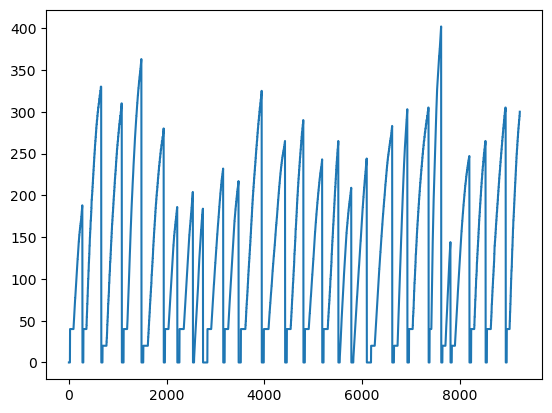

In [179]:
import matplotlib.pyplot as plt
cdfe = Control_df_edit.reset_index()
plt.plot(cdfe['Power'])